## Load Data and Initial Grid Search

In [1]:
DATA_NAME = 'approx1e5-spaceNet-fourier-blue' # size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'group')
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\spaceNet\\fourier\\approx1e5\\blue'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # For quick testing purposes
print("Check that this <= 1e5 if approx1e5:", group_data_map[sorted(group_data_map)[-1]].size)
group_total_samples 

Check that this <= 1e5 if approx1e5: 100000


{2: 47614,
 3: 54416,
 4: 61218,
 5: 102030,
 6: 156446,
 7: 197258,
 8: 326496,
 9: 421724,
 10: 639388,
 11: 904666,
 12: 1312786,
 13: 1904560,
 14: 2727602,
 15: 3958764,
 16: 5720482,
 17: 8298440,
 18: 11957916,
 19: 17270278,
 20: 25140192,
 21: 36322680,
 22: 52586262,
 23: 65734528}

In [5]:
def create_kurt_var_ksstat_df(cdf_dict):
    cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(cdf_dict.items())})
    cdfs_df['r'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[0])
    cdfs_df['eta'] = pd.Series(cdfs_df["(r,eta),cdf"].str[0].str[1])
    cdfs_df['cdf'] = pd.Series(cdfs_df["(r,eta),cdf"].str[1])
    cdfs_df['variance'] = np.nan_to_num(cdfs_df.apply(lambda row : variance_prior(row.loc['r'], row.loc['eta']), axis = 1))
    cdfs_df['kurtosis'] = cdfs_df.apply(lambda row : kurtosis_prior(row.loc['r'], row.loc['eta']), axis = 1)
    return cdfs_df

In [6]:
''' Only need to run commented code once'''
all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
all_cdfs_df.head()

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:817: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:822: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:822: RuntimeWarning: overflow encountered in scalar power
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:822: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = 3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2


(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

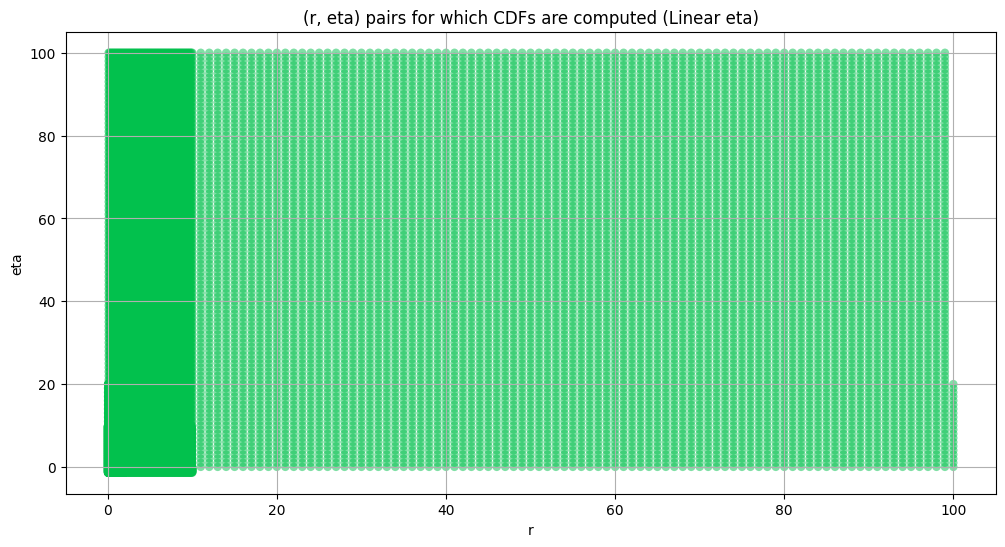

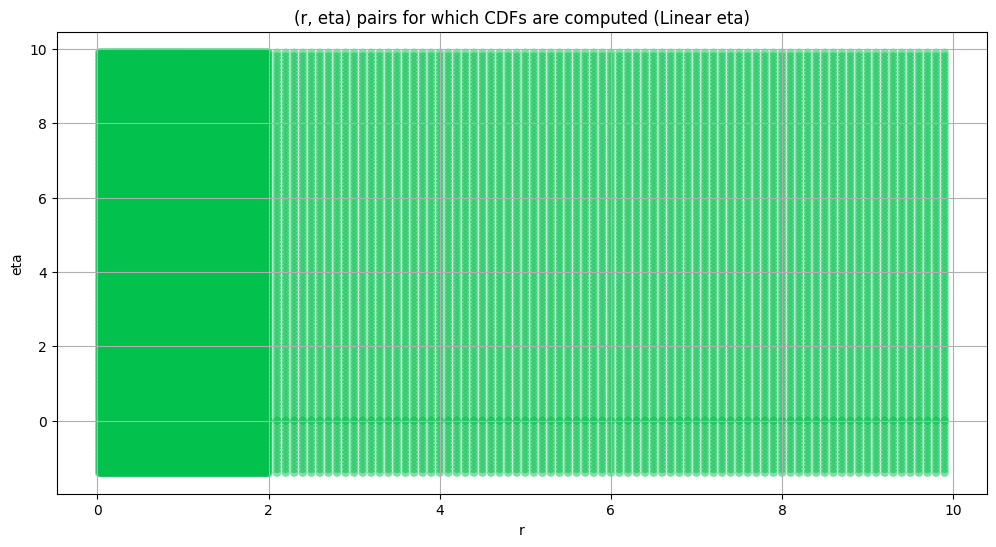

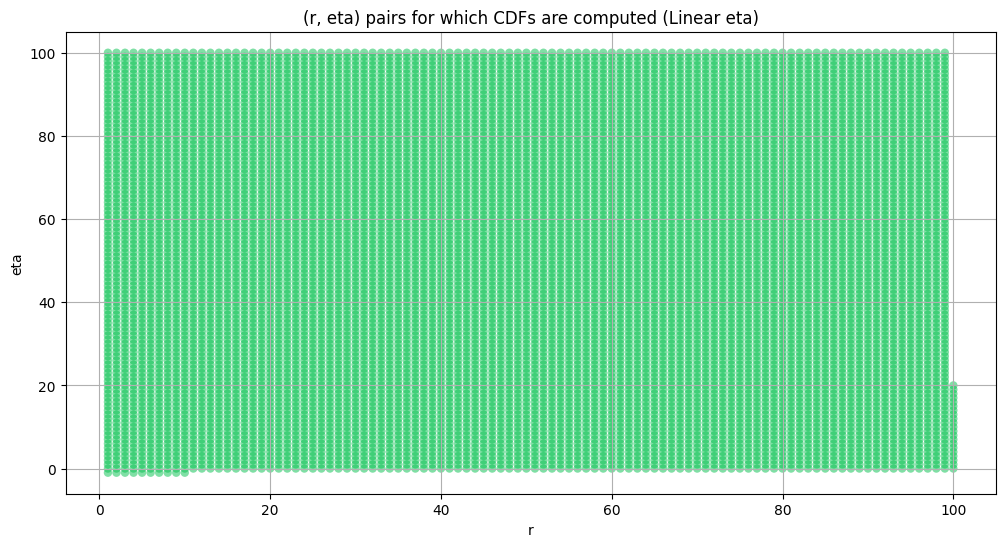

c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
c:\Users\yashd\.conda\envs\hbmv_backup2\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


r           eta       variance      kurtosis
count  51883.000000  51883.000000   5.188300e+04  5.064200e+04
mean      11.990701     21.476312            inf           inf
std       22.639851     28.237512            inf           NaN
min        0.020000     -1.400000   0.000000e+00  4.787254e-04
25%        1.000000      3.000000   9.882555e-01  1.513901e-02
50%        1.970000      7.600000   1.482803e+00  1.950077e-01
75%        8.100000     32.000000   5.742021e+00  6.565170e-01
max      100.000000    100.000000  1.797693e+308           inf

In [7]:
create_scatter_plot(all_cdfs_df)
create_scatter_plot(all_cdfs_df[(all_cdfs_df['r'] < 10) & (all_cdfs_df['eta'] < 10)])
create_scatter_plot(coarse_cdf_df)

all_cdfs_df.describe()

In [8]:
n_bootstrap = int(1e4)
bootstrap_size = int(1e5)
ci = 0.99

In [9]:
''' Only need to run commented code once'''    
for group in  GROUPS:
    print(f'{GROUP.capitalize()} {group}')
    obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                             n_bootstrap=n_bootstrap, 
                                                                             bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                             metric= np.var, 
                                                                             ci=ci)
    obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                 n_bootstrap=n_bootstrap, 
                                                                                 bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                 metric= stats.kurtosis, ci=ci)  
    master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
    master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
    master_df.loc[group, 'total_samples'] = group_total_samples[group]

master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
var_kurt_df = pd.read_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'), index_col=GROUP)
master_df

Band 2


100%|██████████| 10000/10000 [00:21<00:00, 462.53it/s]


Band 5


100%|██████████| 10000/10000 [00:36<00:00, 272.48it/s]


Band 8


100%|██████████| 10000/10000 [00:38<00:00, 259.40it/s]


Band 11


100%|██████████| 10000/10000 [00:42<00:00, 233.30it/s]


Band 14


100%|██████████| 10000/10000 [00:44<00:00, 225.96it/s]


Band 17


100%|██████████| 10000/10000 [00:41<00:00, 241.47it/s]


Band 20


100%|██████████| 10000/10000 [00:44<00:00, 225.51it/s]


Band 23


100%|██████████| 10000/10000 [00:46<00:00, 215.62it/s]


obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.869573e+08  1.805405e+08  1.936169e+08    6.890562    5.705554   
5     7.474840e+07  7.227341e+07  7.736376e+07   15.030489   11.519076   
8     2.025597e+07  1.965442e+07  2.090655e+07   12.860015    9.832646   
11    4.711756e+06  4.575736e+06  4.856241e+06   11.616290    8.750675   
14    1.357398e+06  1.315806e+06  1.403579e+06   14.224839    8.318135   
17    3.354883e+05  3.199574e+05  3.579159e+05   44.881534   10.012840   
20    5.783251e+04  5.149025e+04  6.947527e+04  406.070486   11.174704   
23    1.338629e+04  1.271203e+04  1.448674e+04   64.435376    6.781557   

      kurt_upper  total_samples  
band                             
2       8.191423        47614.0  
5      19.477760       102030.0  
8      16.874906       326496.0  
11     15.693161       904666.0  
14     24.720621      2727602.0  
17    124.177167      8298440.0  
20    915.552951     25140192.0  
23    164.295968     65734528.0

In [10]:
def add_tests_to_df(cdfs_df, group, var_kurt_df, ksstats):
    cdfs_df['pass_var'] = (cdfs_df['variance'] > var_kurt_df.loc[group, 'var_lower']) & (cdfs_df['variance'] < var_kurt_df.loc[group, 'var_upper'])
    cdfs_df['pass_kurt'] = (cdfs_df['kurtosis'] > var_kurt_df.loc[group, 'kurt_lower']) & (cdfs_df['kurtosis'] < var_kurt_df.loc[group,'kurt_upper'])
    cdfs_df['ksstat'] = ksstats
    cutoff = stats.kstwo(n=var_kurt_df.loc[group, 'total_samples']).isf(0.05)
    cdfs_df['pass_kstest'] = cdfs_df['ksstat'].apply(lambda x: True if x < cutoff else False)
    return cdfs_df

####
Band  2


100%|██████████| 51883/51883 [06:02<00:00, 143.11it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 47614, Without approximation : 47614.0


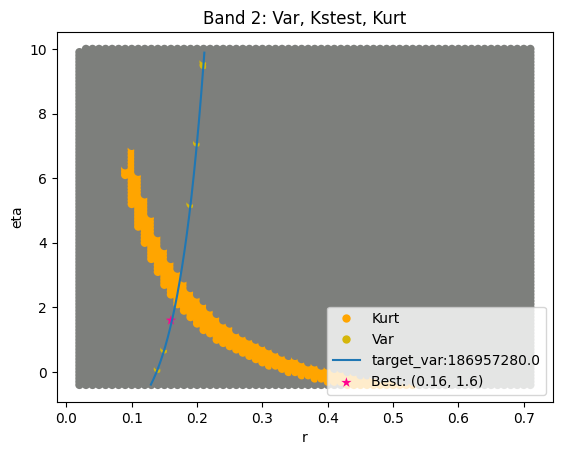

####
Band  5


100%|██████████| 51883/51883 [11:51<00:00, 72.93it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 102030.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


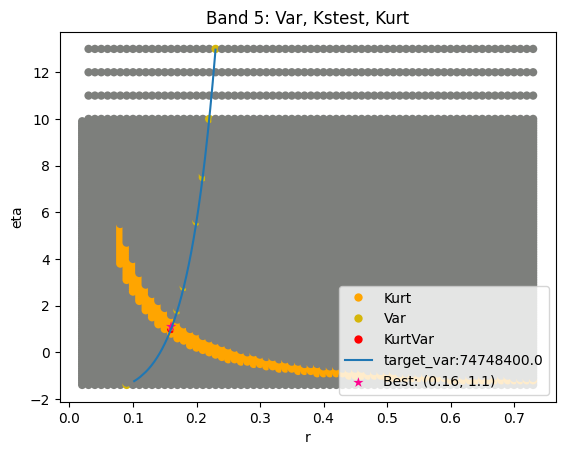

####
Band  8


100%|██████████| 51883/51883 [11:45<00:00, 73.58it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 326496.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


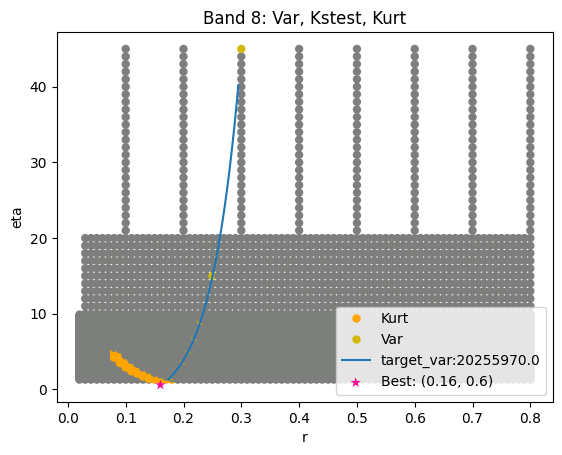

####
Band  11


100%|██████████| 51883/51883 [11:40<00:00, 74.07it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 904666.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


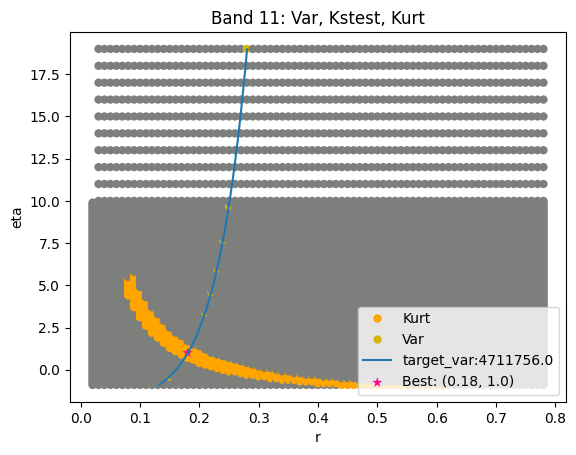

####
Band  14


100%|██████████| 51883/51883 [11:55<00:00, 72.52it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 2727602.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


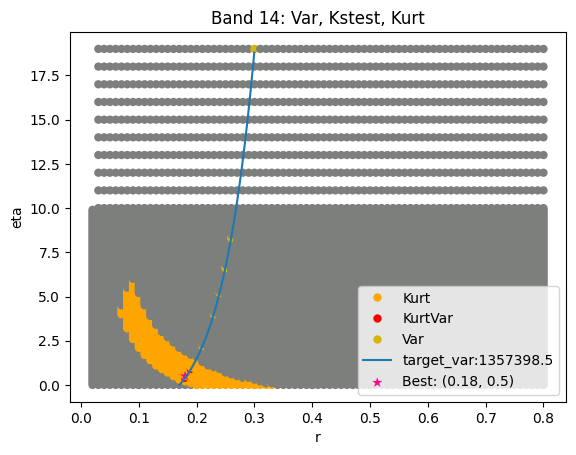

####
Band  17


100%|██████████| 51883/51883 [11:57<00:00, 72.30it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 8298440.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


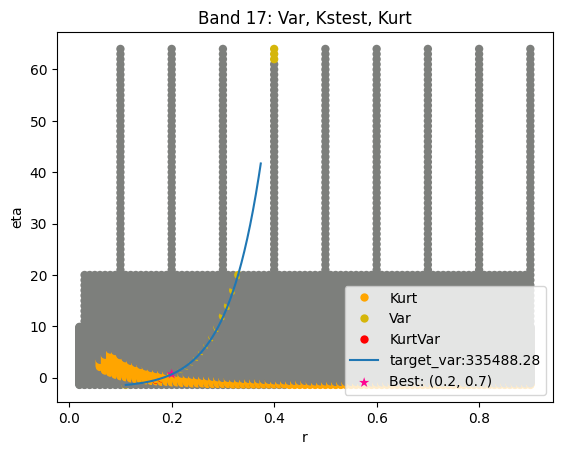

####
Band  20


100%|██████████| 51883/51883 [11:55<00:00, 72.51it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 25140192.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


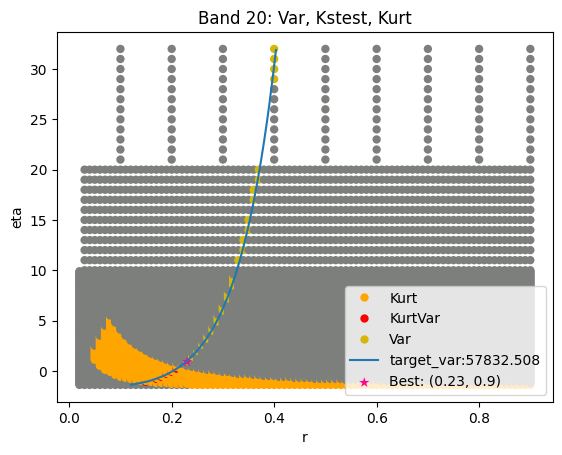

####
Band  23


100%|██████████| 51883/51883 [11:56<00:00, 72.38it/s]


Finding Minimum after computing 51883 CDFs
Number of samples: 100000, Without approximation : 65734528.0


c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\utilities\testing.py:842: RuntimeWarning: invalid value encountered in scalar divide
  return scipy.special.gamma((eta+2.5)/r) / scipy.special.gamma((eta+1.5)/r)


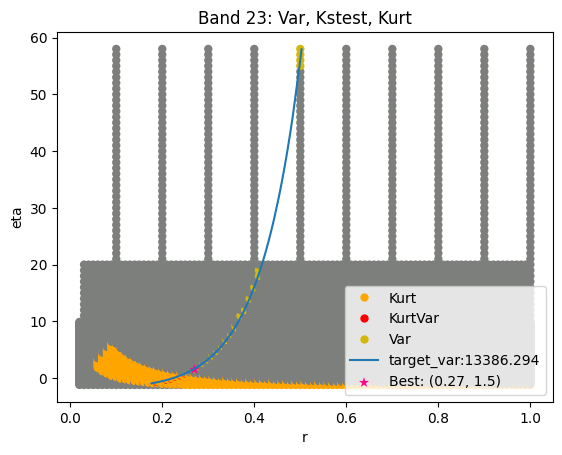

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.869573e+08  1.805405e+08  1.936169e+08    6.890562    5.705554   
5     7.474840e+07  7.227341e+07  7.736376e+07   15.030489   11.519076   
8     2.025597e+07  1.965442e+07  2.090655e+07   12.860015    9.832646   
11    4.711756e+06  4.575736e+06  4.856241e+06   11.616290    8.750675   
14    1.357398e+06  1.315806e+06  1.403579e+06   14.224839    8.318135   
17    3.354883e+05  3.199574e+05  3.579159e+05   44.881534   10.012840   
20    5.783251e+04  5.149025e+04  6.947527e+04  406.070486   11.174704   
23    1.338629e+04  1.271203e+04  1.448674e+04   64.435376    6.781557   

      kurt_upper  total_samples  initial_r  initial_eta  kstest_stat_initial  \
band                                                                           
2       8.191423        47614.0       0.16          1.6             0.015444   
5      19.477760       102030.0       0.16          1.1             0.014587   
8      16.874906       326496.0       0.16          0.6             0.011405   
11     15.693161       904666.0       0.18          1.0             0.013080   
14     24.720621      2727602.0       0.18          0.5             0.010025   
17    124.177167      8298440.0       0.20          0.7             0.009726   
20    915.552951     25140192.0       0.23          0.9             0.006876   
23    164.295968     65734528.0       0.27          1.5             0.004493   

      kstest_stat_cutoff_0.05  
band                           
2                    0.006220  
5                    0.004250  
8                    0.002376  
11                   0.001428  
14                   0.000822  
17                   0.000471  
20                   0.000271  
23                   0.000168

In [11]:
''' Only need to run commented code once'''
sorted_params = sorted(all_cdfs)
group_cdf_df_dict = dict()

for i, group in enumerate(GROUPS):
    print(f"####\n{GROUP.capitalize()} ", group)
    sample = group_data_map[group]
    group_cdf_df = all_cdfs_df.copy()
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True)
    master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
    print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
    master_df.loc[group, 'kstest_stat_initial'] = min_stat
    cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

    group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
    
    group_cdf_df_dict[group] = group_cdf_df
    cols = ['pass_var', 'pass_kstest', 'pass_kurt']

    fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                          plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                          target_var = master_df.loc[group, 'obs_var'],
                          best_param = initial_param)
    
    fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)

    # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
    # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

    # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    # plt.close(fig_var)
    # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
    # plt.close(fig_kurt)

master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
pd.to_pickle(group_cdf_df_dict, os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))

group_cdf_df_dict = pd.read_pickle(os.path.join(CWD, "cache", "group_cdf_df_dict_full.pickle"))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"), index_col=GROUP)
master_df

In [12]:
''' Only need to run commented code once'''
best_params_eta0 = []
for i, group in enumerate(GROUPS):
    if master_df.loc[group, 'initial_eta'] != 0:
        sample = group_data_map[group]
        group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
        cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
        ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True)
        best_params_eta0.append(best_param_eta0[0])
        master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
    else:
        master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
        best_params_eta0.append(master_df.loc[group, 'initial_r'])
master_df['best_r_eta0'] = best_params_eta0
master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"), index_col=GROUP)
master_df

100%|██████████| 369/369 [00:03<00:00, 118.76it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:07<00:00, 52.27it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:06<00:00, 55.33it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:05<00:00, 67.26it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:05<00:00, 66.97it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:05<00:00, 68.23it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:05<00:00, 68.87it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:05<00:00, 71.78it/s]

Finding Minimum after computing 369 CDFs


obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.869573e+08  1.805405e+08  1.936169e+08    6.890562    5.705554   
5     7.474840e+07  7.227341e+07  7.736376e+07   15.030489   11.519076   
8     2.025597e+07  1.965442e+07  2.090655e+07   12.860015    9.832646   
11    4.711756e+06  4.575736e+06  4.856241e+06   11.616290    8.750675   
14    1.357398e+06  1.315806e+06  1.403579e+06   14.224839    8.318135   
17    3.354883e+05  3.199574e+05  3.579159e+05   44.881534   10.012840   
20    5.783251e+04  5.149025e+04  6.947527e+04  406.070486   11.174704   
23    1.338629e+04  1.271203e+04  1.448674e+04   64.435376    6.781557   

      kurt_upper  total_samples  initial_r  initial_eta  kstest_stat_initial  \
band                                                                           
2       8.191423        47614.0       0.16          1.6             0.015444   
5      19.477760       102030.0       0.16          1.1             0.014587   
8      16.874906       326496.0       0.16          0.6             0.011405   
11     15.693161       904666.0       0.18          1.0             0.013080   
14     24.720621      2727602.0       0.18          0.5             0.010025   
17    124.177167      8298440.0       0.20          0.7             0.009726   
20    915.552951     25140192.0       0.23          0.9             0.006876   
23    164.295968     65734528.0       0.27          1.5             0.004493   

      kstest_stat_cutoff_0.05  kstest_stat_eta0  best_r_eta0  
band                                                          
2                    0.006220          0.049129         0.13  
5                    0.004250          0.051694         0.14  
8                    0.002376          0.067774         0.15  
11                   0.001428          0.061547         0.15  
14                   0.000822          0.052946         0.17  
17                   0.000471          0.025961         0.18  
20                   0.000271          0.022218         0.20  
23                   0.000168          0.038541         0.22

In [13]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2
(0.152, 1.57), 50 of 441
(0.154, 1.65), 100 of 441
(0.157, 1.52), 150 of 441
(0.159, 1.6), 200 of 441
(0.161, 1.68), 250 of 441
(0.164, 1.55), 300 of 441
(0.166, 1.63), 350 of 441
(0.169, 1.5), 400 of 441


100%|██████████| 441/441 [00:02<00:00, 153.23it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 2 best parameters: ((0.16, 1.53), 0.012634516490074299)


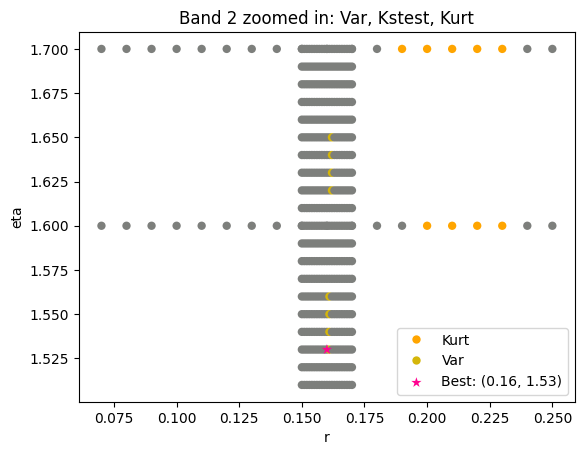

Band 5
(0.152, 1.07), 50 of 441
(0.154, 1.15), 100 of 441
(0.157, 1.02), 150 of 441
(0.159, 1.1), 200 of 441
(0.161, 1.18), 250 of 441
(0.164, 1.05), 300 of 441
(0.166, 1.13), 350 of 441
(0.169, 1.0), 400 of 441


100%|██████████| 441/441 [00:06<00:00, 73.13it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 5 best parameters: ((0.161, 1.09), 0.013009480342219937)


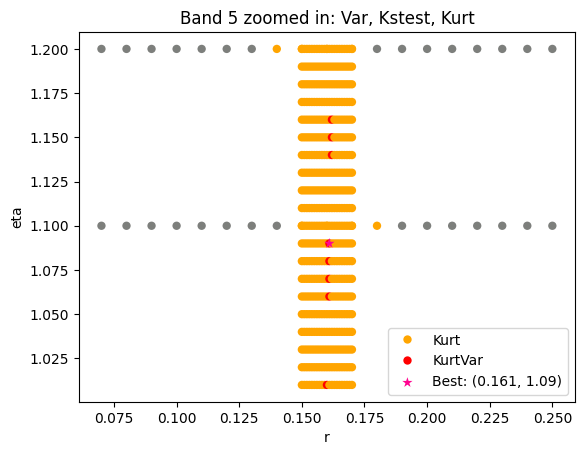

Band 8
(0.152, 0.59), 50 of 420
(0.154, 0.69), 100 of 420
(0.157, 0.59), 150 of 420
(0.159, 0.69), 200 of 420
(0.162, 0.59), 250 of 420
(0.164, 0.69), 300 of 420
(0.167, 0.59), 350 of 420
(0.169, 0.69), 400 of 420


100%|██████████| 420/420 [00:06<00:00, 67.64it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 8 best parameters: ((0.159, 0.54), 0.010749095416101362)


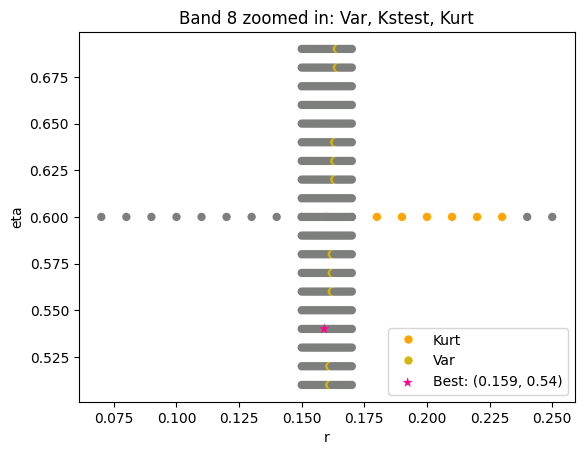

Band 11
(0.172, 0.97), 50 of 441
(0.174, 1.05), 100 of 441
(0.177, 0.92), 150 of 441
(0.179, 1.0), 200 of 441
(0.181, 1.08), 250 of 441
(0.184, 0.95), 300 of 441
(0.186, 1.03), 350 of 441
(0.189, 0.9), 400 of 441


100%|██████████| 441/441 [00:06<00:00, 69.77it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 11 best parameters: ((0.179, 0.91), 0.011668440640125288)


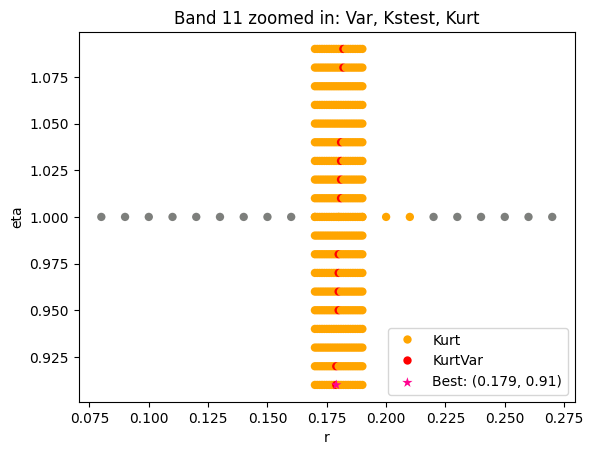

Band 14
(0.172, 0.49), 50 of 420
(0.174, 0.59), 100 of 420
(0.177, 0.49), 150 of 420
(0.179, 0.59), 200 of 420
(0.182, 0.49), 250 of 420
(0.184, 0.59), 300 of 420
(0.187, 0.49), 350 of 420
(0.189, 0.59), 400 of 420


100%|██████████| 420/420 [00:05<00:00, 70.70it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 14 best parameters: ((0.178, 0.41), 0.00867972627705238)


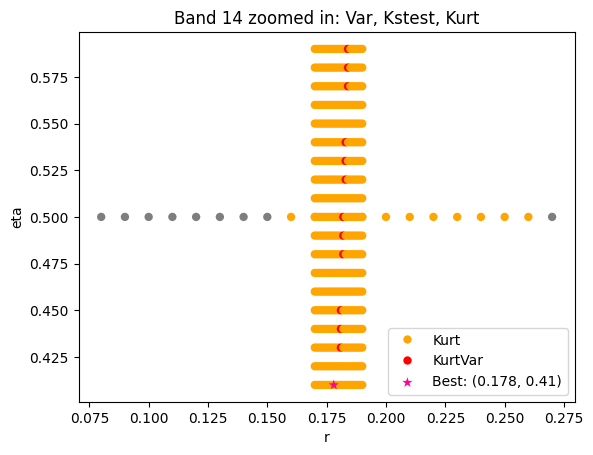

Band 17
(0.192, 0.69), 50 of 420
(0.194, 0.79), 100 of 420
(0.197, 0.69), 150 of 420
(0.199, 0.79), 200 of 420
(0.202, 0.69), 250 of 420
(0.204, 0.79), 300 of 420
(0.207, 0.69), 350 of 420
(0.209, 0.79), 400 of 420


100%|██████████| 420/420 [00:05<00:00, 70.72it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 17 best parameters: ((0.199, 0.62), 0.006765296956533495)


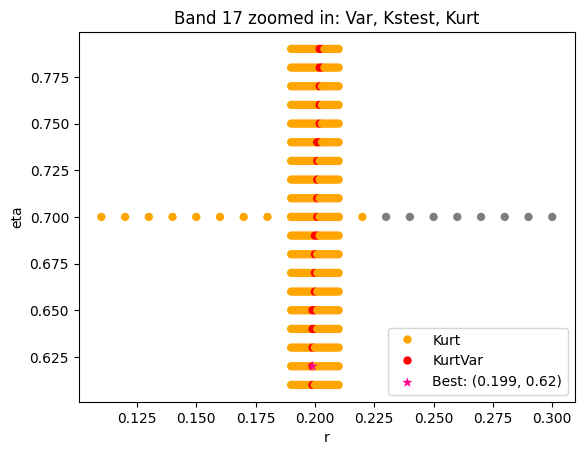

Band 20
(0.222, 0.89), 50 of 420
(0.224, 0.99), 100 of 420
(0.227, 0.89), 150 of 420
(0.229, 0.99), 200 of 420
(0.232, 0.89), 250 of 420
(0.234, 0.99), 300 of 420
(0.237, 0.89), 350 of 420
(0.239, 0.99), 400 of 420


100%|██████████| 420/420 [00:06<00:00, 65.35it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 20 best parameters: ((0.228, 0.8), 0.0018182673071805155)


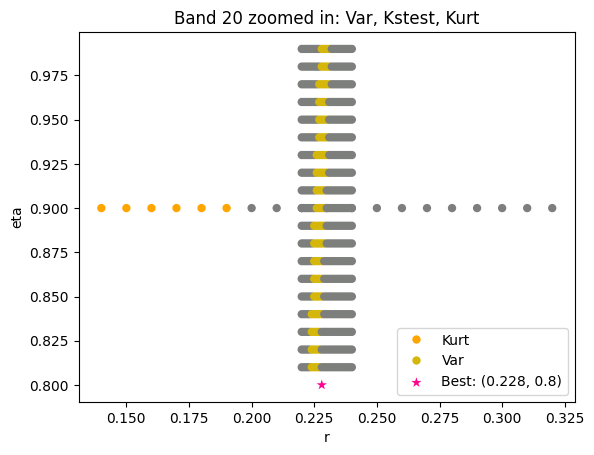

Band 23
(0.262, 1.47), 50 of 441
(0.264, 1.55), 100 of 441
(0.267, 1.42), 150 of 441
(0.269, 1.5), 200 of 441
(0.271, 1.58), 250 of 441
(0.274, 1.45), 300 of 441
(0.276, 1.53), 350 of 441
(0.279, 1.4), 400 of 441


100%|██████████| 441/441 [00:08<00:00, 54.43it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 23 best parameters: ((0.267, 1.4), 0.0032283464808345874)


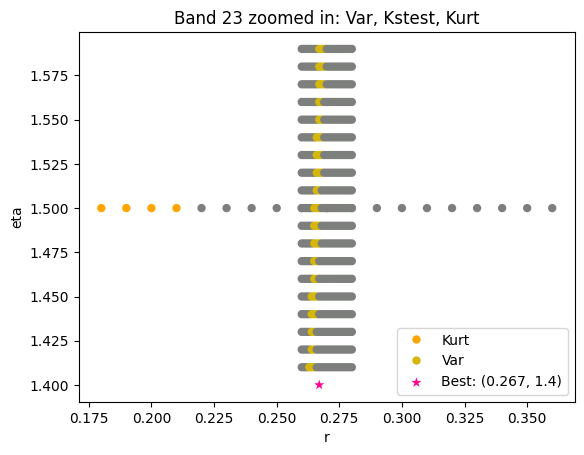

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.869573e+08  1.805405e+08  1.936169e+08    6.890562    5.705554   
5     7.474840e+07  7.227341e+07  7.736376e+07   15.030489   11.519076   
8     2.025597e+07  1.965442e+07  2.090655e+07   12.860015    9.832646   
11    4.711756e+06  4.575736e+06  4.856241e+06   11.616290    8.750675   
14    1.357398e+06  1.315806e+06  1.403579e+06   14.224839    8.318135   
17    3.354883e+05  3.199574e+05  3.579159e+05   44.881534   10.012840   
20    5.783251e+04  5.149025e+04  6.947527e+04  406.070486   11.174704   
23    1.338629e+04  1.271203e+04  1.448674e+04   64.435376    6.781557   

      kurt_upper  total_samples  initial_r  initial_eta  kstest_stat_initial  \
band                                                                           
2       8.191423        47614.0       0.16          1.6             0.015444   
5      19.477760       102030.0       0.16          1.1             0.014587   
8      16.874906       326496.0       0.16          0.6             0.011405   
11     15.693161       904666.0       0.18          1.0             0.013080   
14     24.720621      2727602.0       0.18          0.5             0.010025   
17    124.177167      8298440.0       0.20          0.7             0.009726   
20    915.552951     25140192.0       0.23          0.9             0.006876   
23    164.295968     65734528.0       0.27          1.5             0.004493   

      kstest_stat_cutoff_0.05  kstest_stat_eta0  best_r_eta0  best_r  \
band                                                                   
2                    0.006220          0.049129         0.13   0.160   
5                    0.004250          0.051694         0.14   0.161   
8                    0.002376          0.067774         0.15   0.159   
11                   0.001428          0.061547         0.15   0.179   
14                   0.000822          0.052946         0.17   0.178   
17                   0.000471          0.025961         0.18   0.199   
20                   0.000271          0.022218         0.20   0.228   
23                   0.000168          0.038541         0.22   0.267   

      best_eta  kstest_stat_best  iter1_r  iter1_eta  kstest_stat_iter1  \
band                                                                      
2         1.53          0.012635    0.160       1.53           0.012635   
5         1.09          0.013009    0.161       1.09           0.013009   
8         0.54          0.010749    0.159       0.54           0.010749   
11        0.91          0.011668    0.179       0.91           0.011668   
14        0.41          0.008680    0.178       0.41           0.008680   
17        0.62          0.006765    0.199       0.62           0.006765   
20        0.80          0.001818    0.228       0.80           0.001818   
23        1.40          0.003228    0.267       1.40           0.003228   

      n_pval_0.05  
band               
2           11903  
5           10759  
8           15304  
11          14135  
14          23971  
17          41023  
20         589222  
23         182799

In [14]:
SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1, 1, 1, 1, 1, 1, 1, 1]))
NUM_SAMPLES_OPTIMIZE = 2000

if SKIP_OPTIMIZE_STEP:
    master_df['kstest_stat'] = master_df['kstest_stat_initial']
    master_df[f'best_r'] = master_df['initial_r']
    master_df[f'best_eta'] = master_df['initial_eta']
else:
    for group in GROUPS: 
        print(f"{GROUP.capitalize()} {group}")
        sample = group_data_map[group]
        initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
        r_granularity = 10
        eta_granularity = 10
        for i in range(-1, -5, -1):
            if tuple([round_to_sigfigs(initial_r + 10.**i), initial_eta]) in all_cdfs:
                r_granularity = 10.**i
            if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i)]) in all_cdfs:
                
                eta_granularity = 10.**i

        for d in range(1, NUM_ITERS[group] + 1):
            if d == 1:
                initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            else:
                initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
            r_granularity = r_granularity * 10.0**(-d+1) 
            eta_granularity = eta_granularity * 10.0**(-d+1) 

            r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
            eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
            simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
            cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
            ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True)

            temp_df = create_kurt_var_ksstat_df(cdfs_dict)
            temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
            group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
            master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
            master_df.loc[group, 'kstest_stat_best'] = kstest_stat
            master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
            master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
            
            print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

        temp_df = group_cdf_df_dict[group]
        eps = 0.1
        filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                        (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                        (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                        (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']
        fig = combo_test_plot(filtered_df, cols, 
                              plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                              best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']))
        fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=600)
        
master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', f'best_r', f'best_eta', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'), index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

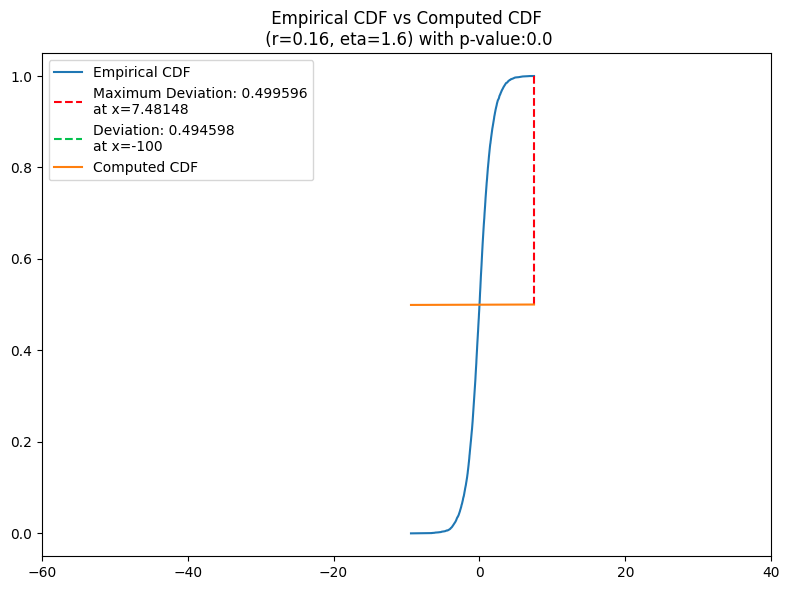

In [15]:
# Example Cell
group = 2
visualize_cdf(sample = sample_prior(1, 1, 10000), 
              all_cdfs = None, 
              params = (master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta']),
              distro = 'gengamma',
              n_samples=200, 
              interval = (-60, 40), 
              provided_loc = -100);

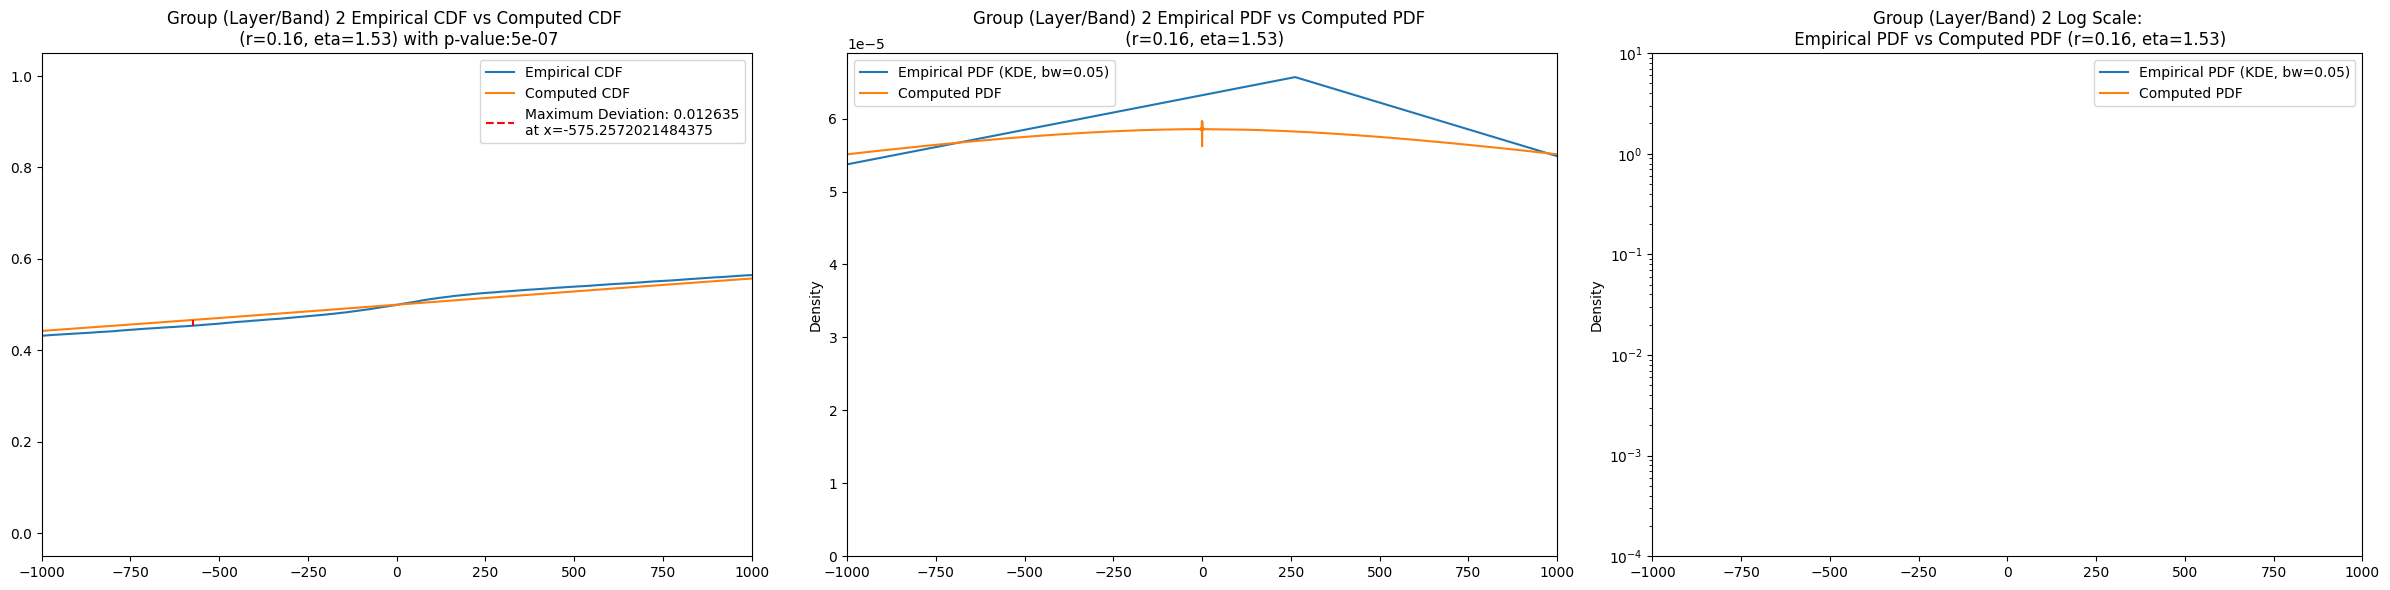

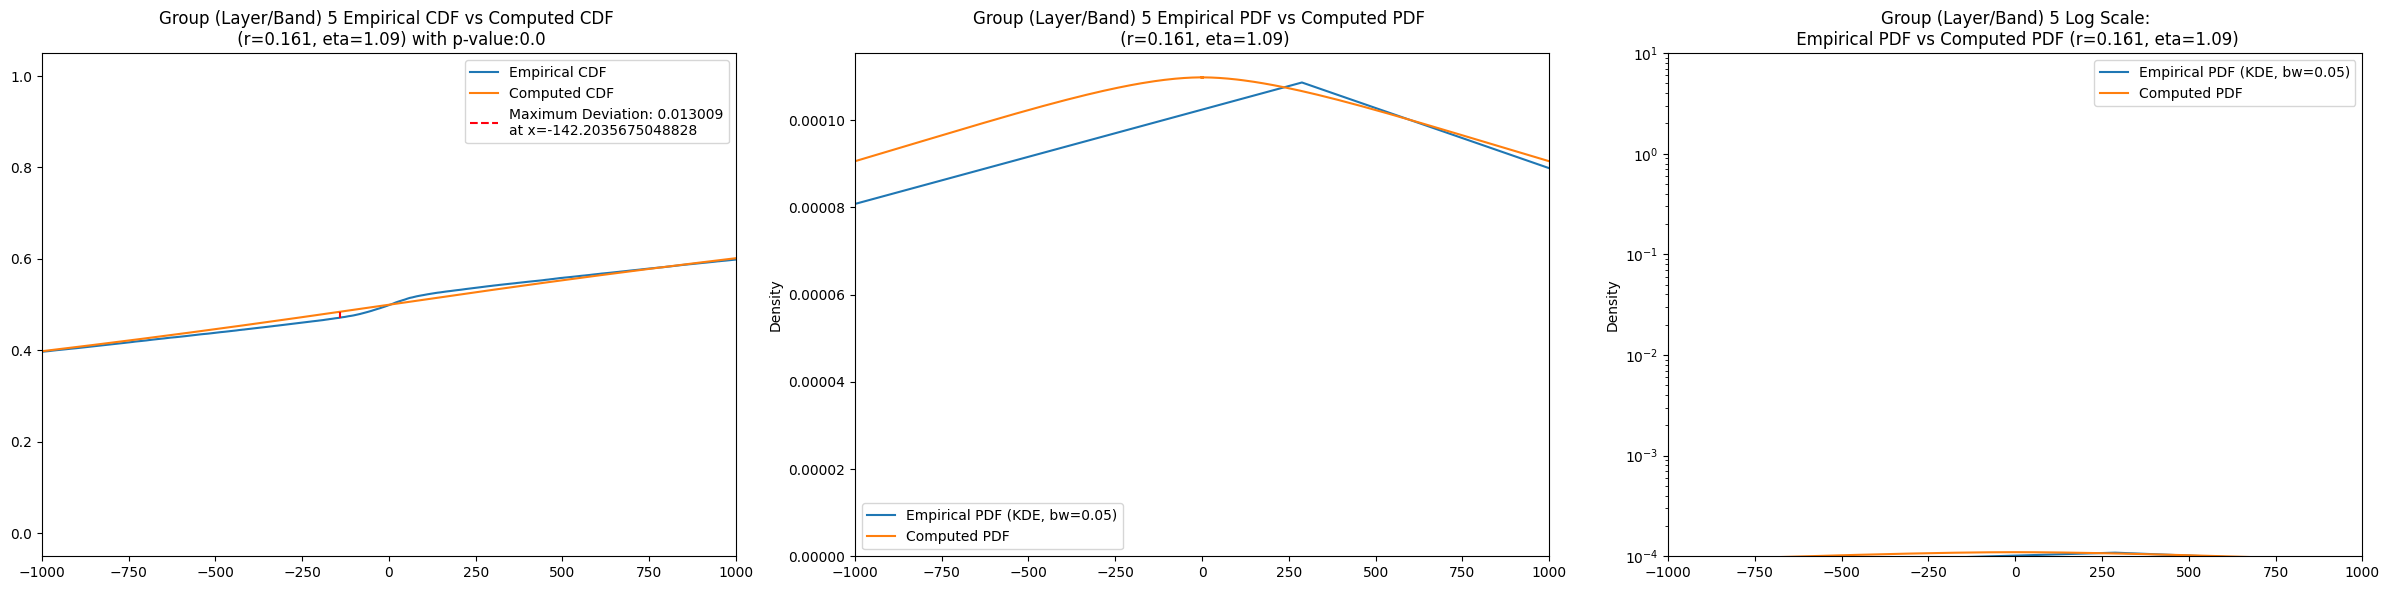

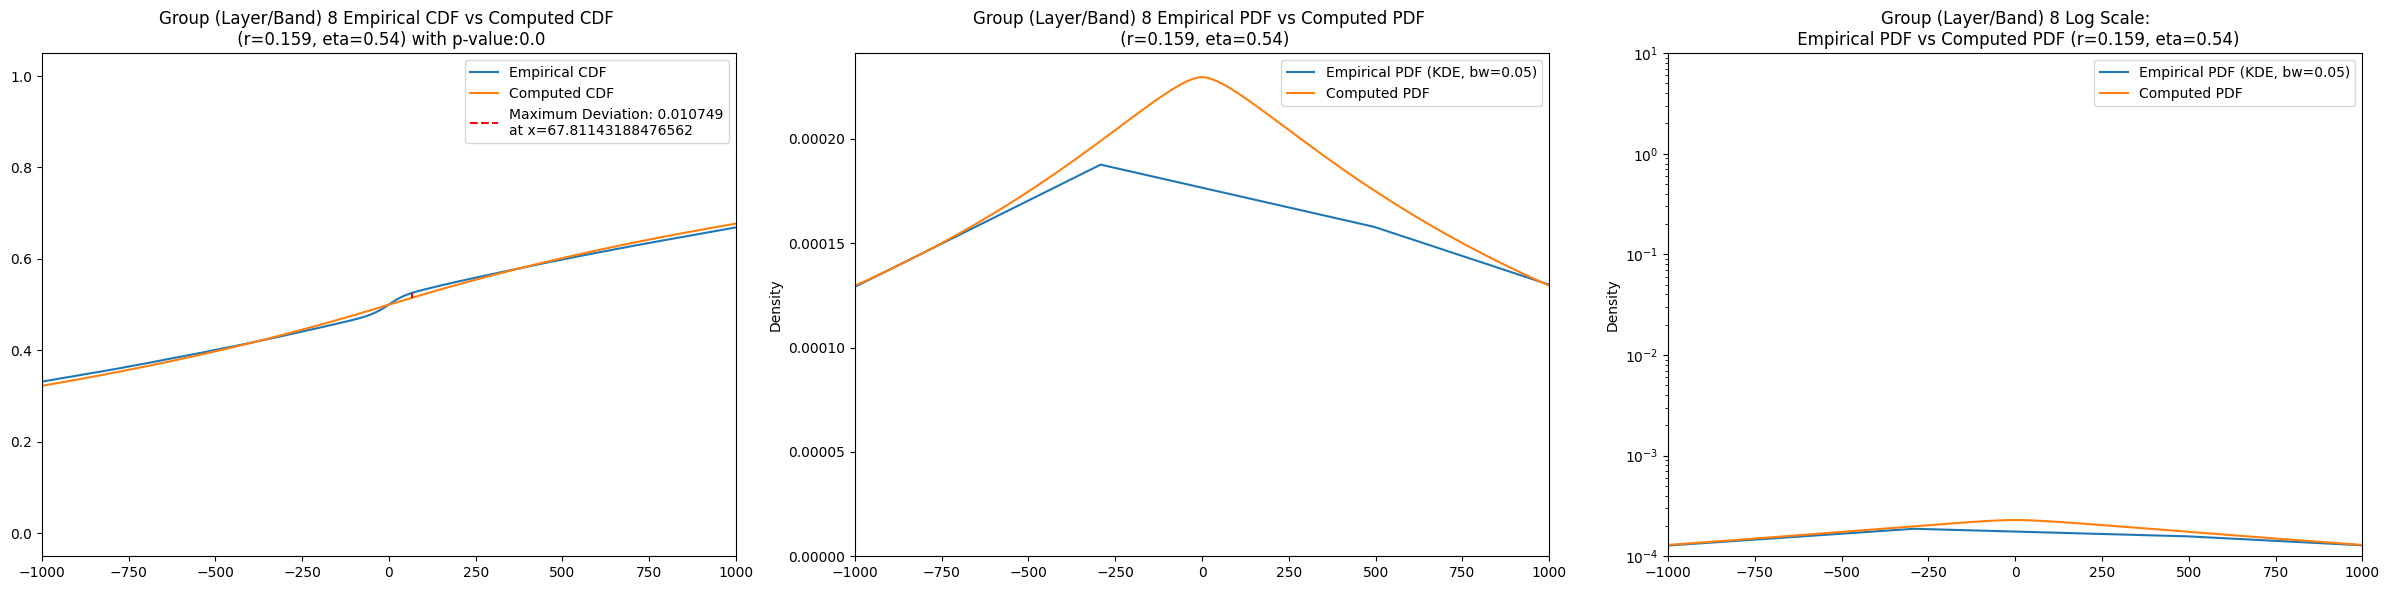

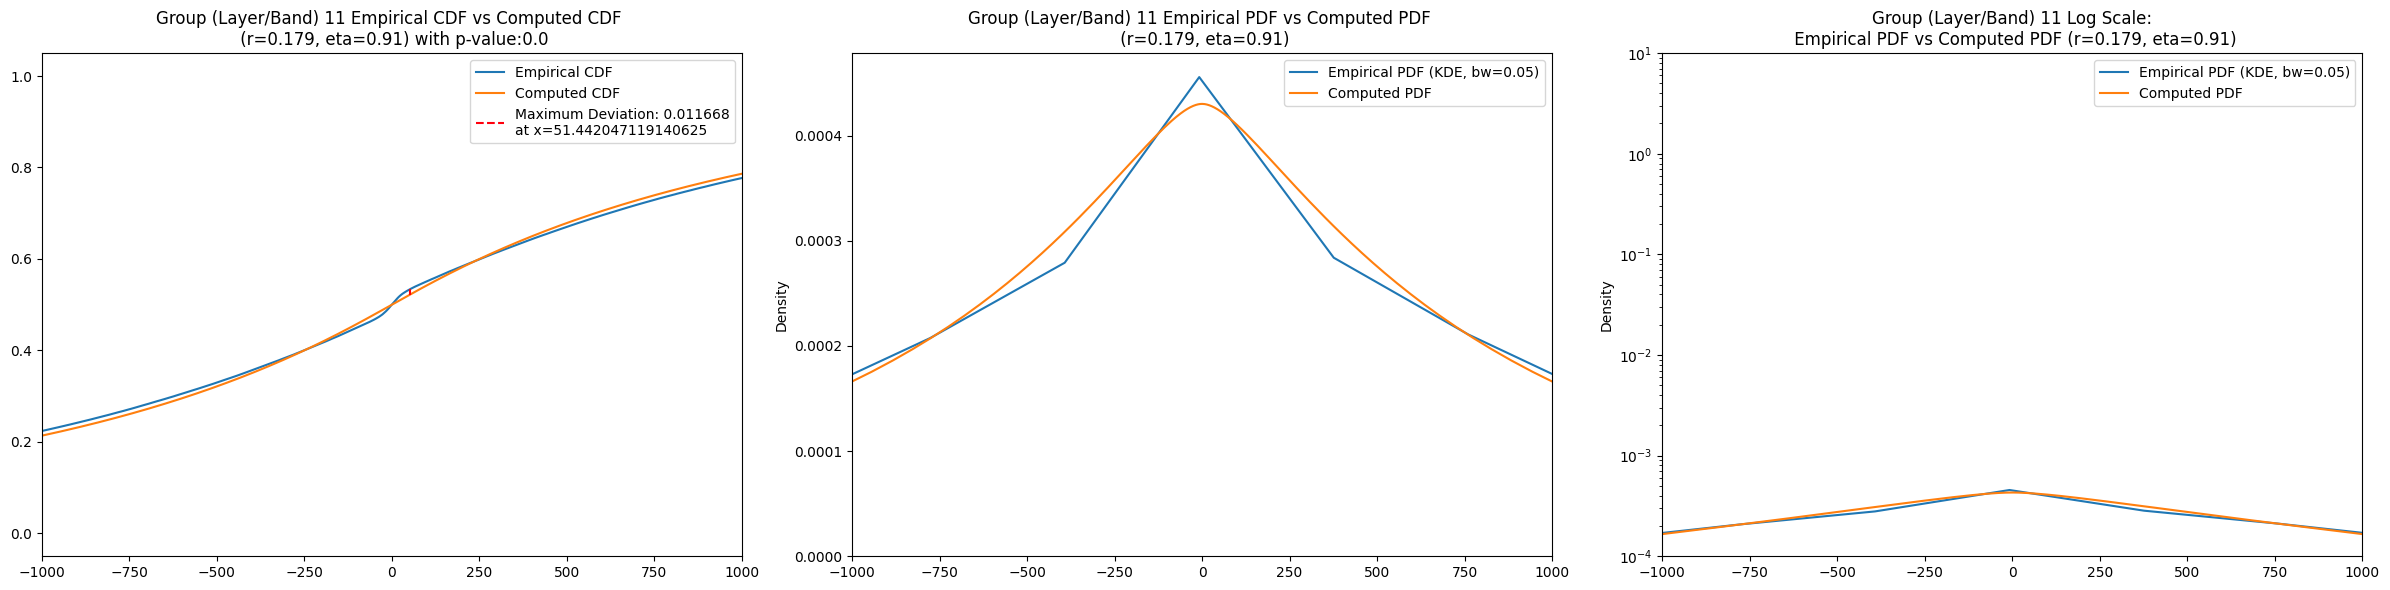

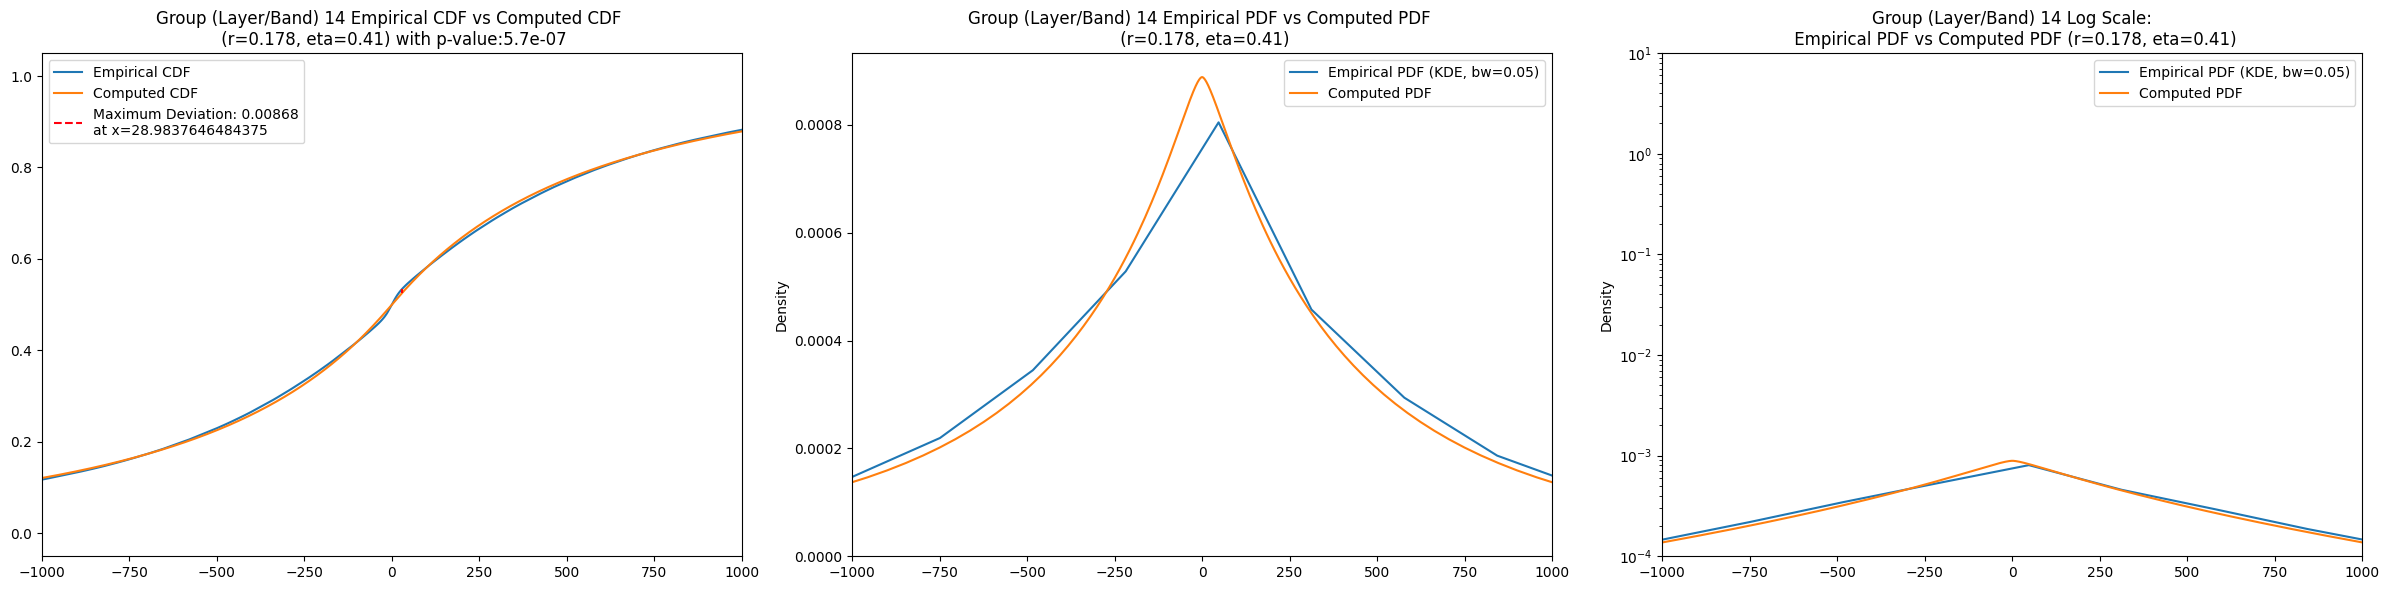

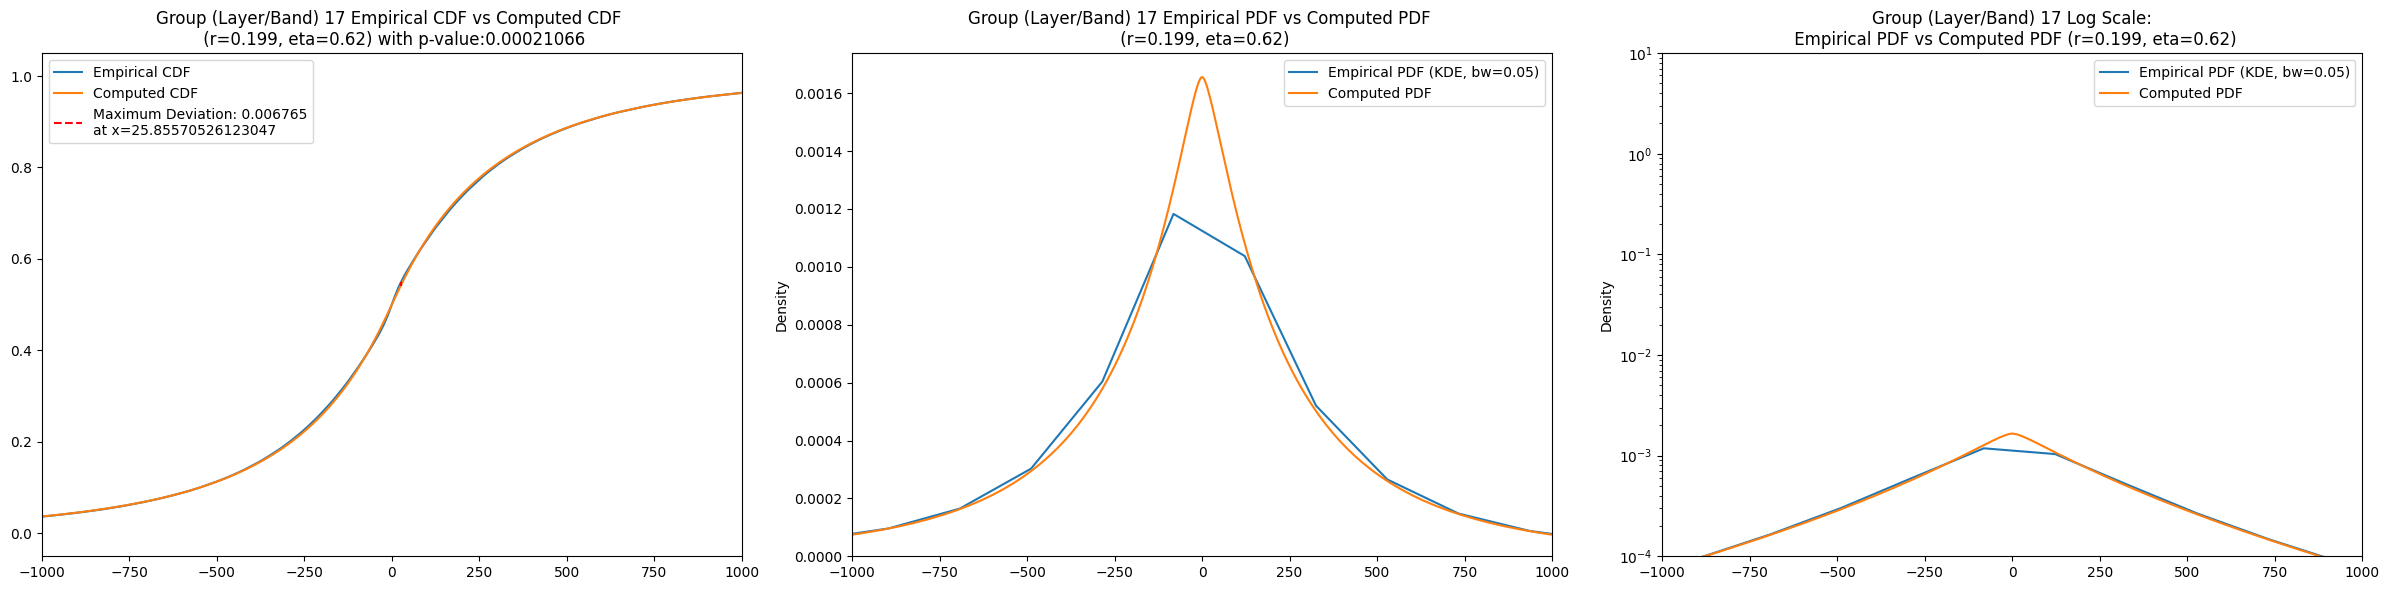

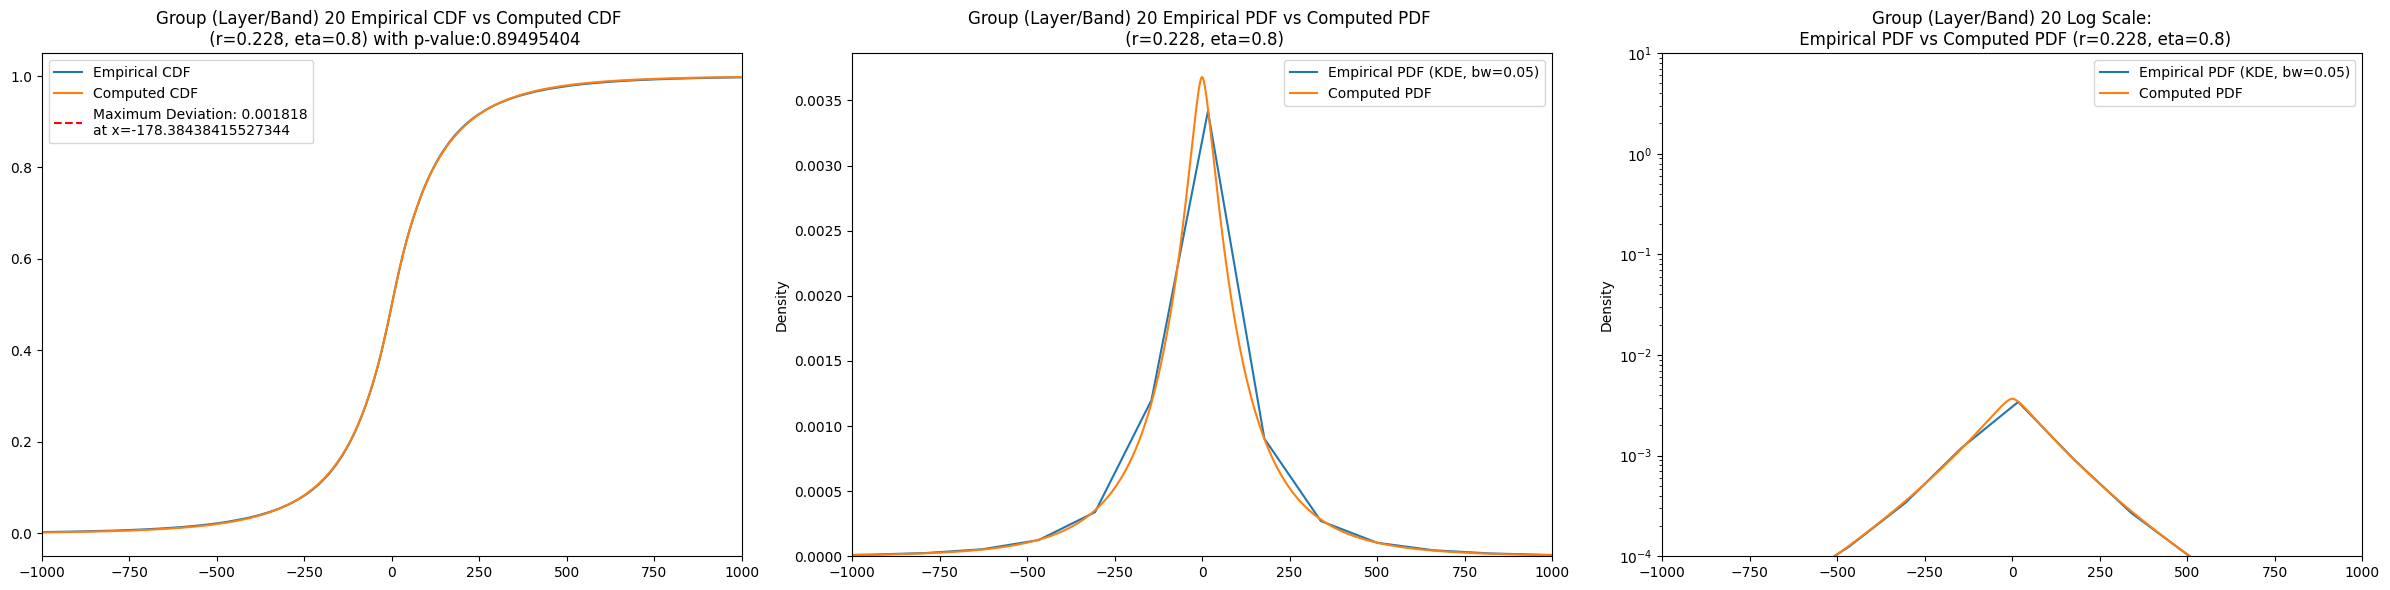

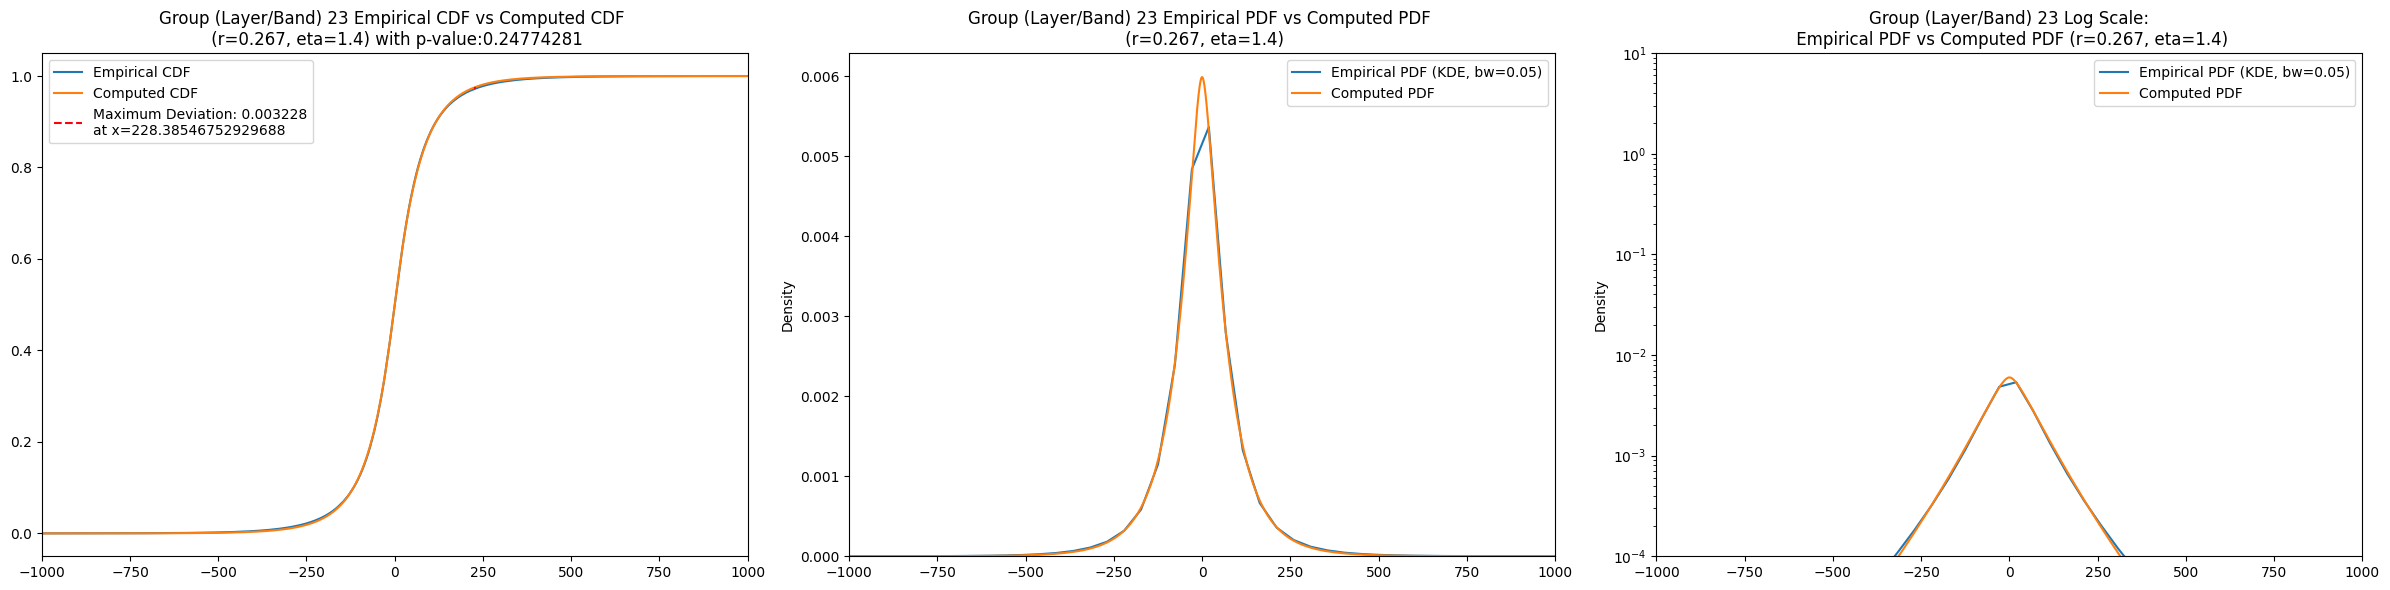

In [16]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta), 
                    log_scale = True,
                    group = group,
                    interval = (-1000, 1000))#,
                    #provided_loc=(30 - group//3.1*8))
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace

In [17]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior', 't'")

In [6]:
for group in GROUPS:
    upper_bound = int(1e5)
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.869573e+08  1.805405e+08  1.936169e+08    6.890562    5.705554   
5     7.474840e+07  7.227341e+07  7.736376e+07   15.030489   11.519076   
8     2.025597e+07  1.965442e+07  2.090655e+07   12.860015    9.832646   
11    4.711756e+06  4.575736e+06  4.856241e+06   11.616290    8.750675   
14    1.357398e+06  1.315806e+06  1.403579e+06   14.224839    8.318135   
17    3.354883e+05  3.199574e+05  3.579159e+05   44.881534   10.012840   
20    5.783251e+04  5.149025e+04  6.947527e+04  406.070486   11.174704   
23    1.338629e+04  1.271203e+04  1.448674e+04   64.435376    6.781557   

      kurt_upper  total_samples  initial_r  initial_eta  kstest_stat_initial  \
band                                                                           
2       8.191423        47614.0       0.16          1.6             0.015444   
5      19.477760       102030.0       0.16          1.1             0.014587   
8      16.874906       326496.0       0.16          0.6             0.011405   
11     15.693161       904666.0       0.18          1.0             0.013080   
14     24.720621      2727602.0       0.18          0.5             0.010025   
17    124.177167      8298440.0       0.20          0.7             0.009726   
20    915.552951     25140192.0       0.23          0.9             0.006876   
23    164.295968     65734528.0       0.27          1.5             0.004493   

      ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band  ...                                                               
2     ...       9923.0300              0.035071          2.556660e-51   
5     ...       5758.3400              0.038778         9.552010e-134   
8     ...       3000.7600              0.038661          0.000000e+00   
11    ...       1474.3200              0.037614          0.000000e+00   
14    ...        773.9670              0.039890          0.000000e+00   
17    ...        378.5720              0.038914          0.000000e+00   
20    ...        154.7660              0.035723          0.000000e+00   
23    ...         85.0871              0.029534          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         8332.2100             0.012682         4.426920e-07  6988.0500   
5         4871.7900             0.014545         3.536980e-19  4006.9800   
8         2560.1700             0.013946         1.379110e-55  2071.9000   
11        1249.8100             0.013636        1.491570e-146  1016.1200   
14         670.9180             0.013866         0.000000e+00   533.4010   
17         331.6910             0.012295         0.000000e+00   261.9830   
20         136.5360             0.009519         0.000000e+00   109.2550   
23          73.6498             0.005128         0.000000e+00    60.2651   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.017813   1.488010e-13          4.958000e-07  
5          0.017676   4.031720e-28          1.984900e-15  
8          0.016843   6.906370e-81          3.389600e-33  
11         0.016499  2.427080e-214         2.033000e-107  
14         0.016788   0.000000e+00         6.474400e-179  
17         0.015440   0.000000e+00          0.000000e+00  
20         0.009374   0.000000e+00          1.279300e-72  
23         0.006043   0.000000e+00          0.000000e+00  

[8 rows x 30 columns]

# Examining Tail Behavior

In [19]:
# def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
#     if metric_name == 'kstest_ratio':
#         metric = compute_ksratio
#     elif metric_name == 'kstest_stat':
#         metric = compute_ksstat_tail

#     for tail_cutoff in tail_cutoffs:
#         metrics = []
#         for layer in layers:
#             if distro == 'gengamma':
#                 cdf = all_cdfs[(master_df.loc[layer, 'initial_r'], master_df.loc[layer, 'initial_eta'])]
#             elif distro == 'gaussian':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
#             elif distro == 'laplace':
#                 cdf = scipy.stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
#             elif distro == 't':
#                 cdf = scipy.stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
#             metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
#         master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
# for group in GROUPS:
#     add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
#     add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
#     add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

# master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

# master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
# master_df

# Results

## KS-Test Statistics

In [20]:
import pandas as pd
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))

In [21]:
master_df.filter(regex='total_samples|kstest_stat.*')
#master_df.filter(regex='total_samples|param.*')
# master_df.filter(regex='.*gaussian')
#master_df.filter(regex='kstest_stat_.*[\_(tail\d)]')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


total_samples  kstest_stat_initial  kstest_stat_cutoff_0.05  \
0        47614.0             0.015444                 0.006220   
1       102030.0             0.014587                 0.004250   
2       326496.0             0.011405                 0.002376   
3       904666.0             0.013080                 0.001428   
4      2727602.0             0.010025                 0.000822   
5      8298440.0             0.009726                 0.000471   
6     25140192.0             0.006876                 0.000271   
7     65734528.0             0.004493                 0.000168   

   kstest_stat_eta0  kstest_stat_best  kstest_stat_iter1  \
0          0.049129          0.012635           0.012635   
1          0.051694          0.013009           0.013009   
2          0.067774          0.010749           0.010749   
3          0.061547          0.011668           0.011668   
4          0.052946          0.008680           0.008680   
5          0.025961          0.006765           0.006765   
6          0.022218          0.001818           0.001818   
7          0.038541          0.003228           0.003228   

   kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
0              0.481435             0.471615       0.458737  
1              0.471551             0.459973       0.445130  
2              0.457751             0.440535       0.422552  
3              0.434929             0.409335       0.388061  
4              0.398262             0.363685       0.340488  
5              0.336236             0.292712       0.268723  
6              0.214464             0.168075       0.143630  
7              0.109092             0.066980       0.040763